Loading dataset...

Loaded 700 images for 50 people
Saving reference images...
Augmenting data...
Preprocessing...
Extracting features...
Reducing dimensions...
Training model...


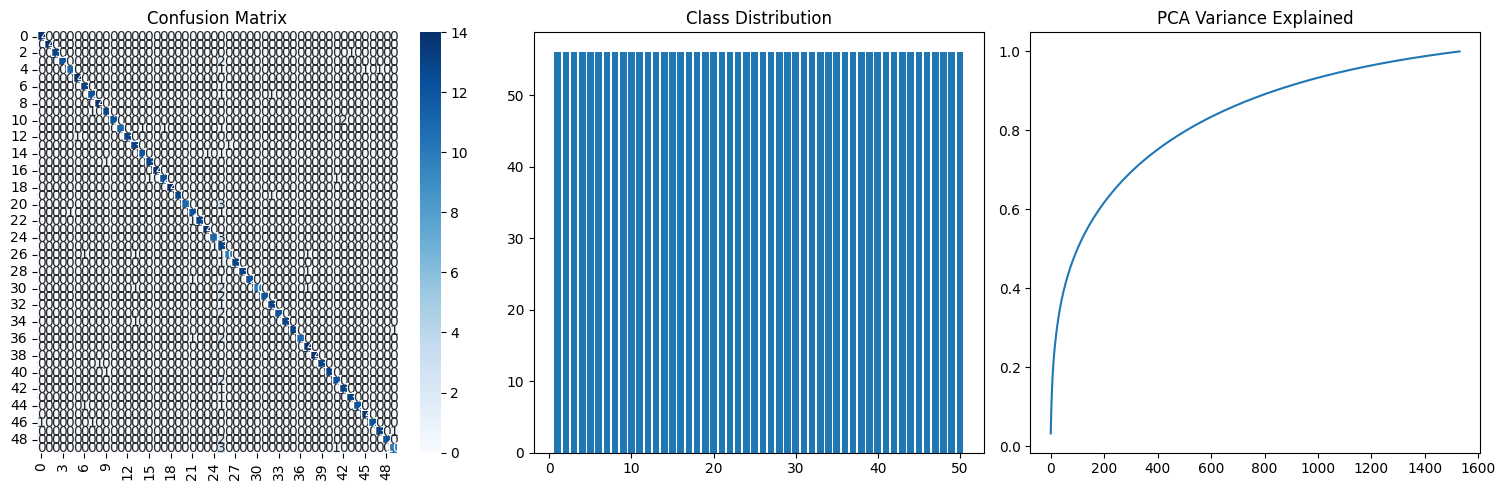


Classification Report:
              precision    recall  f1-score   support

           1      0.933     1.000     0.966        14
           2      1.000     1.000     1.000        14
           3      1.000     0.929     0.963        14
           4      1.000     0.857     0.923        14
           5      0.917     0.786     0.846        14
           6      0.933     1.000     0.966        14
           7      0.867     0.929     0.897        14
           8      0.857     0.857     0.857        14
           9      0.933     1.000     0.966        14
          10      0.867     0.929     0.897        14
          11      1.000     0.857     0.923        14
          12      1.000     0.786     0.880        14
          13      1.000     0.929     0.963        14
          14      0.812     0.929     0.867        14
          15      0.923     0.857     0.889        14
          16      0.929     0.929     0.929        14
          17      1.000     1.000     1.000        14
   

In [14]:
# === FACE RECOGNITION TRAINING WITH STATISTICS ===
import os
import cv2
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuration
MODEL_DIR = r"C:\Users\Selim\OneDrive\Bureau\gestion-proj\gestion-de-projets"
os.makedirs(MODEL_DIR, exist_ok=True)

def load_dataset(path, min_images=10):
    images, labels = [], []
    person_counts = {}
    
    for filename in os.listdir(path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                person_id = int(filename.split('-')[0])
                person_counts[person_id] = person_counts.get(person_id, 0) + 1
            except:
                continue
    
    valid_persons = {pid for pid, count in person_counts.items() if count >= min_images}
    
    for filename in sorted(os.listdir(path)):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                person_id = int(filename.split('-')[0])
                if person_id in valid_persons:
                    img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (128, 128))
                        images.append(img)
                        labels.append(person_id)
            except:
                continue
    
    print(f"\nLoaded {len(images)} images for {len(valid_persons)} people")
    return np.array(images), np.array(labels)

def save_reference_images(images, labels):
    reference_dir = os.path.join(MODEL_DIR, "reference_images")
    os.makedirs(reference_dir, exist_ok=True)
    
    unique_persons = np.unique(labels)
    for person_id in unique_persons:
        idx = np.where(labels == person_id)[0][0]
        ref_img = images[idx]
        cv2.imwrite(os.path.join(reference_dir, f"{person_id}.jpg"), 
                   (ref_img * 255).astype(np.uint8))

def augment_data(images, labels, augment_factor=4):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        brightness_range=[0.8, 1.2]
    )
    
    augmented_images, augmented_labels = [], []
    
    for img, label in zip(images, labels):
        img = img.reshape(128, 128, 1)
        for _ in range(augment_factor):
            transformed = datagen.random_transform(img)
            augmented_images.append(transformed[:,:,0])
            augmented_labels.append(label)
    
    return np.concatenate([images, np.array(augmented_images)]), np.concatenate([labels, np.array(augmented_labels)])

def extract_features(images):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
    
    rgb_images = np.repeat(images[..., np.newaxis], 3, axis=-1)
    cnn_features = model.predict(rgb_images, batch_size=32, verbose=0)
    cnn_features = cnn_features.reshape(cnn_features.shape[0], -1)
    
    lbp_features = []
    for img in images:
        img_uint8 = (img * 255).astype(np.uint8)
        lbp = local_binary_pattern(img_uint8, 24, 3, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27))
        hist = hist.astype("float32") / (hist.sum() + 1e-6)
        lbp_features.append(hist)
    
    return cnn_features, np.array(lbp_features)

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    unique, counts = np.unique(y_train, return_counts=True)
    class_weights = {u: sum(counts)/(len(counts)*c) for u, c in zip(unique, counts)}
    
    svm = SVC(
        C=5,
        gamma='scale',
        kernel='rbf',
        class_weight=class_weights,
        probability=True,
        decision_function_shape='ovr'
    )
    
    svm.fit(X_train, y_train)
    
    # Training Statistics
    y_pred = svm.predict(X_test)
    
    plt.figure(figsize=(15, 5))
    
    # 1. Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # 2. Class Distribution
    plt.subplot(1, 3, 2)
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(unique, counts)
    plt.title('Class Distribution')
    
    # 3. Feature Importance (PCA)
    plt.subplot(1, 3, 3)
    pca = PCA().fit(X)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA Variance Explained')
    
    plt.tight_layout()
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0, digits=3))
    
    return svm

def train_face_recognition():
    try:
        dataset_path = r"C:\Users\Selim\Downloads\originalimages_part1"
        print("Loading dataset...")
        images, labels = load_dataset(dataset_path, min_images=10)
        
        print("Saving reference images...")
        save_reference_images(images, labels)
        
        print("Augmenting data...")
        images, labels = augment_data(images, labels)
        
        print("Preprocessing...")
        images = images / 255.0
        for i in range(len(images)):
            images[i] = cv2.equalizeHist((images[i] * 255).astype(np.uint8)) / 255.0
        
        print("Extracting features...")
        cnn_feat, lbp_feat = extract_features(images)
        X = np.hstack((
            StandardScaler().fit_transform(cnn_feat),
            StandardScaler().fit_transform(lbp_feat)
        ))
        
        print("Reducing dimensions...")
        pca = PCA(n_components=0.95, svd_solver='full')
        X_reduced = pca.fit_transform(X)
        
        print("Training model...")
        model = train_model(X_reduced, labels)
        
        joblib.dump(model, os.path.join(MODEL_DIR, 'face_model.pkl'))
        joblib.dump(pca, os.path.join(MODEL_DIR, 'pca.pkl'))
        joblib.dump(StandardScaler().fit(cnn_feat), os.path.join(MODEL_DIR, 'scaler_cnn.pkl'))
        joblib.dump(StandardScaler().fit(lbp_feat), os.path.join(MODEL_DIR, 'scaler_lbp.pkl'))
        
        print("\nTraining completed successfully!")
        
    except Exception as e:
        print(f"\nError during training: {str(e)}")

train_face_recognition()

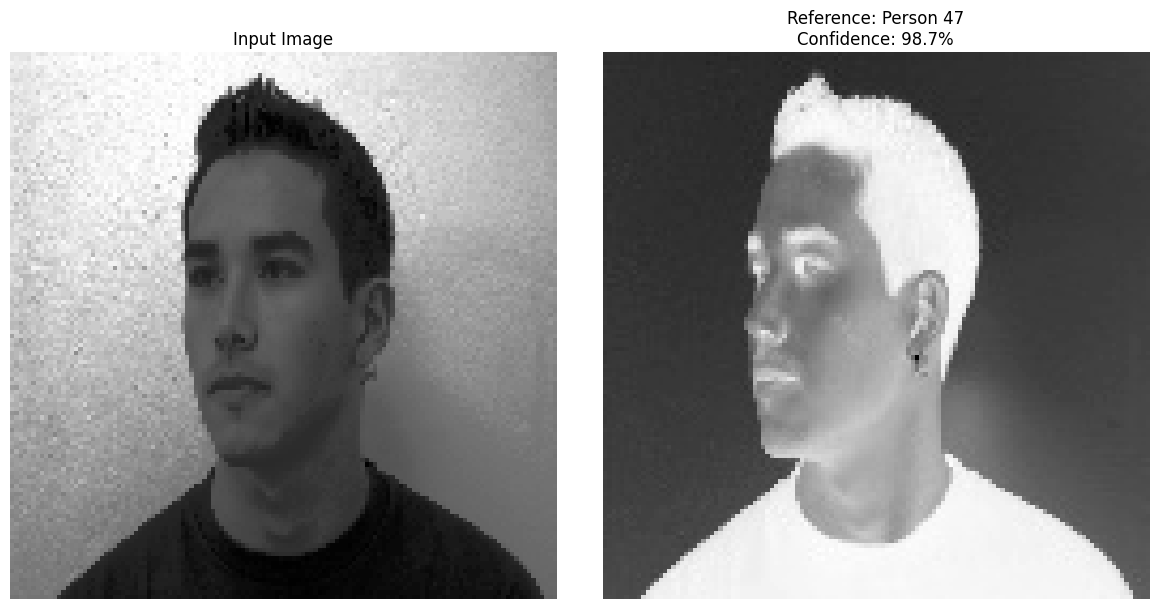

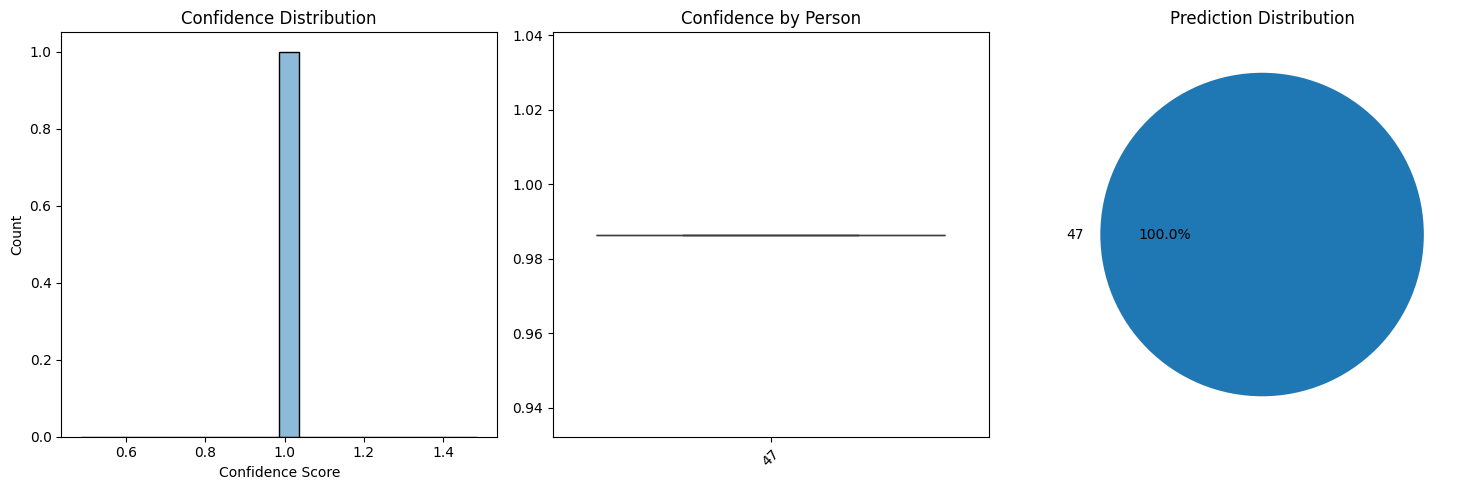

In [15]:
# === FACE RECOGNITION TESTING WITH STATISTICS ===
test_results = []

def recognize_face(image_path):
    try:
        model = joblib.load(os.path.join(MODEL_DIR, 'face_model.pkl'))
        pca = joblib.load(os.path.join(MODEL_DIR, 'pca.pkl'))
        scaler_cnn = joblib.load(os.path.join(MODEL_DIR, 'scaler_cnn.pkl'))
        scaler_lbp = joblib.load(os.path.join(MODEL_DIR, 'scaler_lbp.pkl'))
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")
            
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = cv2.equalizeHist((img * 255).astype(np.uint8)) / 255.0
        
        cnn_feat = extract_features(np.array([img]))[0]
        lbp_feat = extract_features(np.array([img]))[1]
        
        features = np.hstack([
            scaler_cnn.transform(cnn_feat),
            scaler_lbp.transform(lbp_feat)
        ])
        reduced_features = pca.transform(features)
        
        person_id = model.predict(reduced_features)[0]
        confidence = model.predict_proba(reduced_features).max()
        test_results.append((person_id, confidence))
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        ref_path = os.path.join(MODEL_DIR, "reference_images", f"{person_id}.jpg")
        if os.path.exists(ref_path):
            ref_img = cv2.imread(ref_path, cv2.IMREAD_GRAYSCALE)
            plt.subplot(1, 2, 2)
            plt.imshow(ref_img, cmap='gray')
            plt.title(f"Reference: Person {person_id}\nConfidence: {confidence*100:.1f}%")
        else:
            plt.subplot(1, 2, 2)
            plt.text(0.5, 0.5, f"No reference image\nfor Person {person_id}", 
                    ha='center', va='center')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return person_id, confidence
        
    except Exception as e:
        print(f"Error during recognition: {str(e)}")
        return None, 0.0

def show_test_statistics():
    if not test_results:
        print("No test results available")
        return
    
    person_ids, confidences = zip(*test_results)
    
    plt.figure(figsize=(15, 5))
    
    # 1. Confidence Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(confidences, bins=20, kde=True)
    plt.title('Confidence Distribution')
    plt.xlabel('Confidence Score')
    
    # 2. Confidence by Person
    plt.subplot(1, 3, 2)
    sns.boxplot(x=person_ids, y=confidences)
    plt.title('Confidence by Person')
    plt.xticks(rotation=45)
    
    # 3. Prediction Distribution
    plt.subplot(1, 3, 3)
    unique, counts = np.unique(person_ids, return_counts=True)
    plt.pie(counts, labels=unique, autopct='%1.1f%%')
    plt.title('Prediction Distribution')
    
    plt.tight_layout()
    plt.show()

# Test single image
test_image_path = r"C:\Users\Selim\Downloads\originalimages_part1\47-04.jpg"
recognize_face(test_image_path)

# After testing multiple images, show statistics
show_test_statistics()